# Requirements

In [ ]:
!pip install -U bitsandbytes
!pip install vllm --force-reinstall

# Imports

In [1]:
import torch
import gc
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoProcessor
from datasets import load_from_disk
from tqdm import tqdm
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

WARNING 10-10 11:46:24 cuda.py:22] You are using a deprecated `pynvml` package. Please install `nvidia-ml-py` instead, and make sure to uninstall `pynvml`. When both of them are installed, `pynvml` will take precedence and cause errors. See https://pypi.org/project/pynvml for more information.


2024-10-10 11:46:26,136	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Model

In [2]:
model_id = 'neuralmagic/Meta-Llama-3.1-8B-Instruct-quantized.w4a16'
number_gpus = 1
max_model_len = 8192

sampling_params = SamplingParams(temperature=0.6, top_p=0.9, max_tokens=128)

tokenizer = AutoTokenizer.from_pretrained(model_id)

llm = LLM(model=model_id, tensor_parallel_size=number_gpus, max_model_len=max_model_len)

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

WARNING 10-10 11:46:41 config.py:319] gptq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 10-10 11:46:41 llm_engine.py:226] Initializing an LLM engine (v0.6.1.dev238+ge2c6e0a82) with config: model='neuralmagic/Meta-Llama-3.1-8B-Instruct-quantized.w4a16', speculative_config=None, tokenizer='neuralmagic/Meta-Llama-3.1-8B-Instruct-quantized.w4a16', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=gptq, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect

/opt/conda/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/opt/conda/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


INFO 10-10 11:46:44 model_runner.py:1014] Starting to load model neuralmagic/Meta-Llama-3.1-8B-Instruct-quantized.w4a16...
INFO 10-10 11:46:44 selector.py:217] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 10-10 11:46:44 selector.py:116] Using XFormers backend.
INFO 10-10 11:46:44 weight_utils.py:242] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/5.74G [00:00<?, ?B/s]

INFO 10-10 11:47:14 weight_utils.py:287] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 10-10 11:47:17 model_runner.py:1025] Loading model weights took 5.3767 GB
INFO 10-10 11:47:22 gpu_executor.py:122] # GPU blocks: 2777, # CPU blocks: 2048
INFO 10-10 11:47:26 model_runner.py:1329] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 10-10 11:47:26 model_runner.py:1333] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 10-10 11:48:15 model_runner.py:1456] Graph capturing finished in 48 secs.


# Data

In [3]:
data_before_fn = load_from_disk('/kaggle/input/test-dataset-infered/kaggle/working/test_dataset_infered')
data_after_fn = load_from_disk('/kaggle/input/test-dataset-infered-fn/kaggle/working/test_dataset_infered_after_fn')

# Evaluation

In [20]:
system_prompt = '''
    Imagine you are an evaluation of visual language model performance expert. Your task is to evaluate VLM reply on question.
    You will be given the question itself, VLMs response and the correct answer. Give me one float number in range [0, 1], where
    0 means that VLMs answer is irrelevant and 1 means that VLMs answer perfect fits
    Give only one number and nothing else
'''

results_1 = []
for sample in tqdm(data_before_fn):
    torch.cuda.empty_cache()
    gc.collect()
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Question: {sample['query']}, Correct answer: {sample['label']}, VLM answer: {sample['predictions']}"},
    ]
    prompts = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    outputs = llm.generate(prompts, sampling_params)
    generated_text = outputs[0].outputs[0].text
    try:
        res = float(generated_text)
    except:
        res = 0.5
    results_1.append(res)

100%|██████████| 250/250 [03:27<00:00,  1.20it/s]


In [21]:
np.array(results_1).mean()

0.18092000000000003

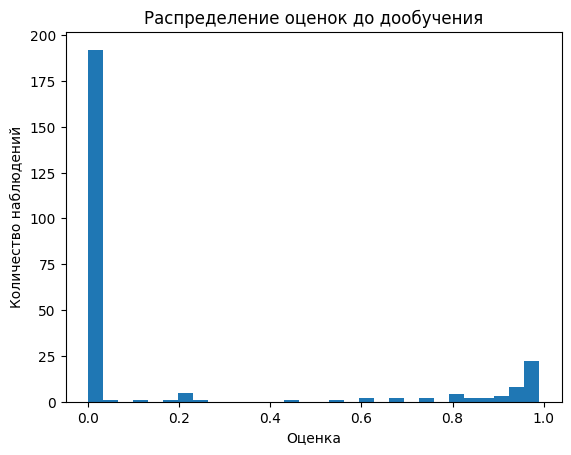

In [23]:
plt.hist(results_1, bins=30)
plt.title('Распределение оценок до дообучения')
plt.xlabel('Оценка')
plt.ylabel('Количество наблюдений');

In [6]:
results_2 = []
for sample in tqdm(data_after_fn):
    torch.cuda.empty_cache()
    gc.collect()
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Question: {sample['query']}, Correct answer: {sample['label']}, VLM answer: {sample['predictions']}"},
    ]
    prompts = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    outputs = llm.generate(prompts, sampling_params)
    generated_text = outputs[0].outputs[0].text
    try:
        res = float(generated_text)
    except:
        res = 0.5
    results_2.append(res)

100%|██████████| 250/250 [02:55<00:00,  1.43it/s]


In [19]:
np.array(results_2).mean()

0.13226933333333332

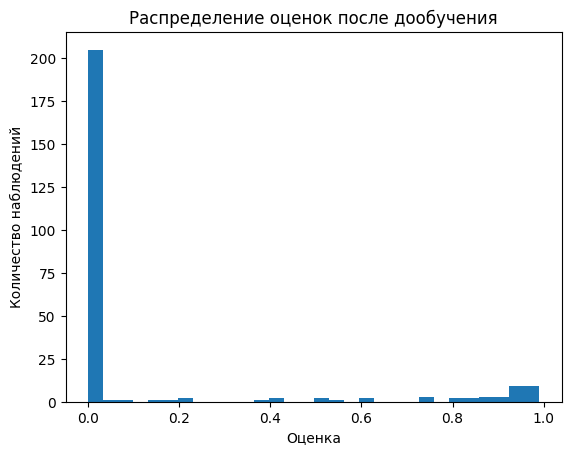

In [17]:
plt.hist(results_2, bins=30)
plt.title('Распределение оценок после дообучения')
plt.xlabel('Оценка')
plt.ylabel('Количество наблюдений');

# Some cases

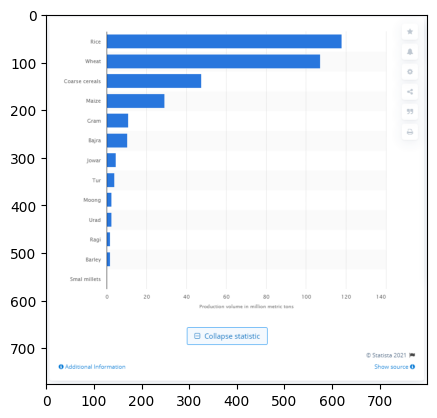

Вопрос: What is one of the staple foods of the south Asian country?, Ответ: Rice
Ответ VLM до дообучения: One of the staple foods of the South Asian country is rice. 
 После дообучения: Brown


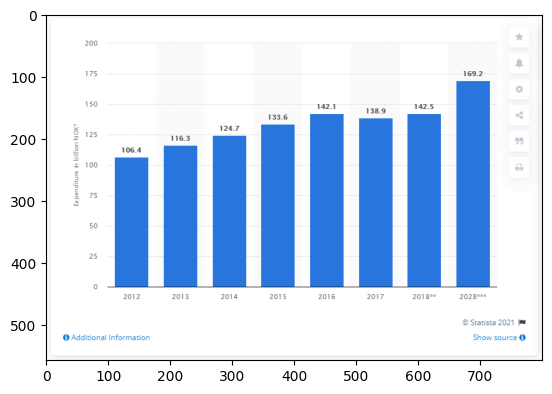

Вопрос: What was the expenditure on outbound travel in Norway in 2017?, Ответ: 138.9
Ответ VLM до дообучения: The expenditure on outbound travel in Norway in 2017 is not provided in the given information. 
 После дообучения: 14


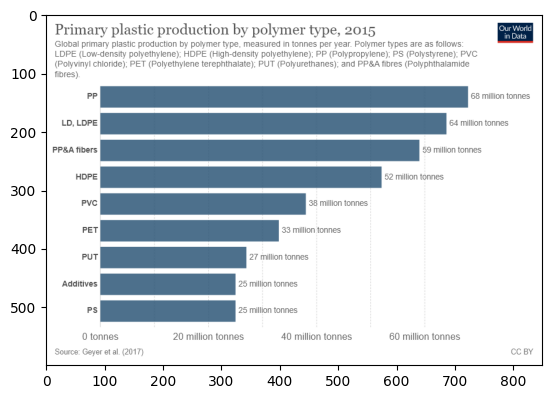

Вопрос: What type of plastic was most produced?, Ответ: PP
Ответ VLM до дообучения: Low-density polyethylene (LD, LDPE) 
 После дообучения: PolyntaxException


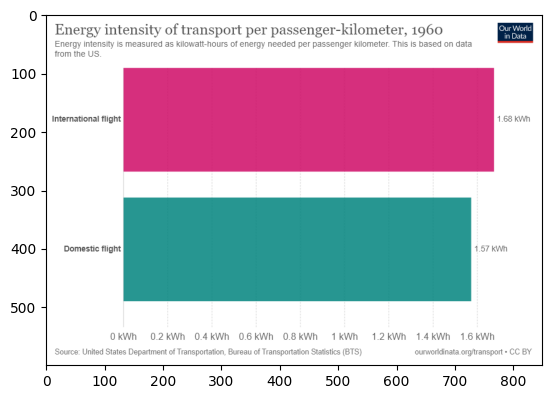

Вопрос: Which color bar represents the International flight?, Ответ: Pink
Ответ VLM до дообучения: The color bar representing the International flight is the blue bar. 
 После дообучения: Red


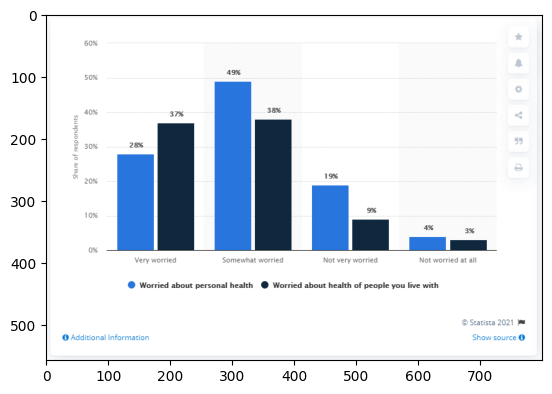

Вопрос: What is value of the highest bar?, Ответ: 49
Ответ VLM до дообучения: The highest bar in the chart represents the percentage of trees that are not very worried (38%). 
 После дообучения: 49


In [45]:
num_samples = 5
indices = np.random.choice(list(range(len(data_after_fn))), num_samples)
for ind in indices:
    sample_before_fn = data_before_fn[int(ind)]
    sample_after_fn = data_after_fn[int(ind)]
    plt.imshow(sample_after_fn['image'])
    plt.show()
    print(f"Вопрос: {sample_after_fn['query']}, Ответ: {sample_after_fn['label'][0]}")
    print(f"Ответ VLM до дообучения: {sample_before_fn['predictions']} \n После дообучения: {sample_after_fn['predictions']}")